In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2    
from sklearn.metrics import confusion_matrix
import os


In [2]:
train_path = 'Arecanut_dataset/Arecanut_dataset/train'
test_path = 'Arecanut_dataset/Arecanut_dataset/test'

print("type of Images in Train dataset"+str(os.listdir(train_path)))
print("type of Images in Test dataset"+str(os.listdir(test_path)))

type of Images in Train dataset['Healthy_Trunk', 'Stem_bleeding', 'healthy_foot', 'stem cracking']
type of Images in Test dataset['Healthy_Trunk', 'Stem_bleeding', 'healthy_foot', 'stem cracking']


Healthy_Trunk images:


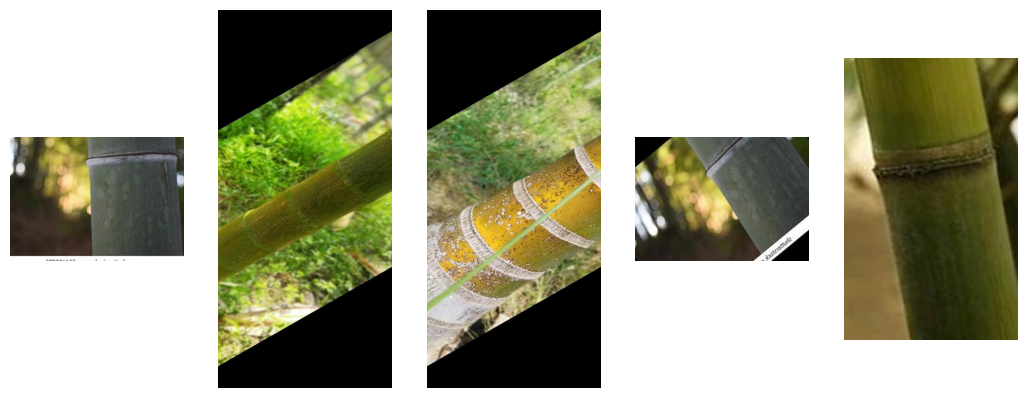

Stem_bleeding images:


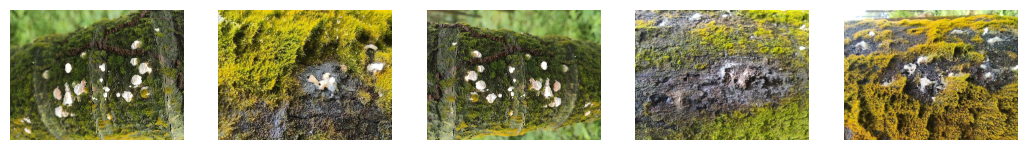

healthy_foot images:


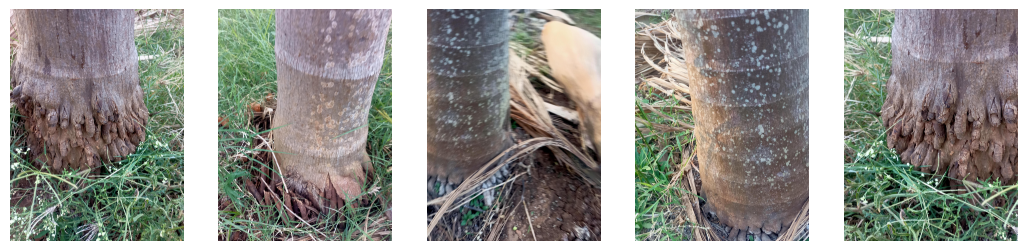

stem cracking images:


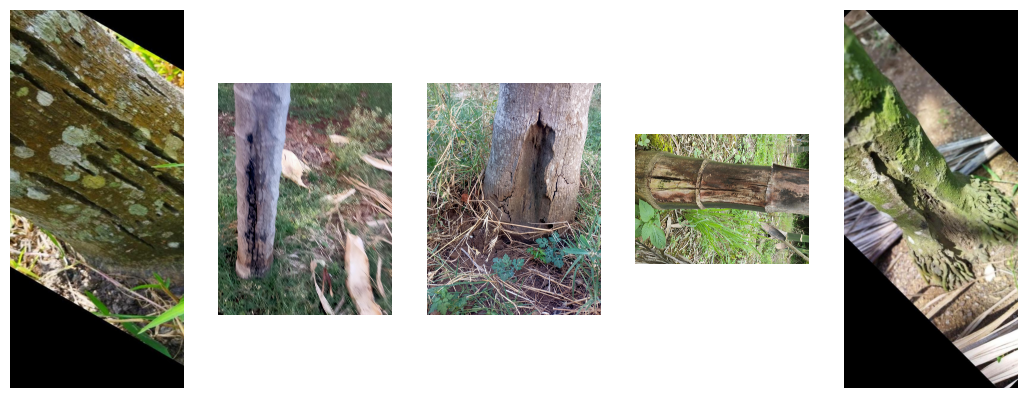

In [3]:
import matplotlib.pyplot as plt

rows, cols = (1, 5)


for category in os.listdir(train_path):
    print(f'{category} images:')
    category_path = os.path.join(train_path, category)
    
    fig = plt.figure(figsize=(13, 8))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i + 1)
        
        # List image files in the specific category's directory
        image_files = os.listdir(category_path)
        if not image_files:
            continue
        
        # Select a random image file from the list
        random_image_id = np.random.choice(image_files)
        image = cv.imread(os.path.join(category_path, random_image_id))
        
        plt.imshow(image[:, :, ::-1])  # Convert BGR to RGB
        #plt.title(random_image_id)
        plt.axis('off')
    
    plt.show()

In [4]:
from tqdm import tqdm
class_names = ['stem cracking', 'Stem_bleeding', 'healthy_foot', 'Healthy_Trunk']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [8]:
def load_data():
    
    
    datasets = ['Arecanut_dataset/Arecanut_dataset/train', 'Arecanut_dataset/Arecanut_dataset/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                #image = cv2.cvtColor(image, cv2.COLOR_RGB2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [9]:
(x_train, y_train), (x_test, y_test) = load_data()


Loading Arecanut_dataset/Arecanut_dataset/train


100%|██████████| 540/540 [00:51<00:00, 10.45it/s]


Loading Arecanut_dataset/Arecanut_dataset/test


100%|██████████| 135/135 [00:09<00:00, 13.90it/s]


In [10]:
batch_size = 64  
epochs = 19
data_augmentation = False
num_classes = 4  # Adjusted for 4 classes

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

n = 3

version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


In [11]:
print(model_type)


ResNet20v1


In [12]:
input_shape = x_train.shape[1:]
print(input_shape)

(150, 150, 3)


In [13]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [ ]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples') 
print('y_train shape:', y_train.shape)

x_train shape: (2173, 150, 150, 3)
2173 train samples
545 test samples
y_train shape: (2173,)


In [15]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [ ]:
def lr_schedule(epoch):
    
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
   
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=4):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=4):
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'IntelImageClass_%s_model.{epoch:03d}.keras' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

Learning rate:  0.001


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 150, 150,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │         64 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 150, 150,  │      2,320 │ activation_19[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │         64 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 150, 150,  │      2,320 │ activation_20[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │         64 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 150, 150,  │          0 │ activation_19[0]… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 150, 150,  │          0 │ add_9[0][0]       │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 150, 150,  │      2,320 │ activation_21[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │         64 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 150, 150,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 150, 150,  │      2,320 │ activation_22[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │         64 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 150, 150,  │          0 │ activation_21[0]

 Total params: 277,892 (1.06 MB)

 Trainable params: 276,516 (1.05 MB)

 Non-trainable params: 1,376 (5.38 KB)

ResNet20v1


In [23]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


Not using data augmentation.
Learning rate:  0.001
Epoch 1/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6454 - loss: 1.4157
Epoch 1: saving model to e:\Internship\Final_Project\saved_models\IntelImageClass_ResNet20v1_model.001.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 311s 8s/step - accuracy: 0.6488 - loss: 1.4015 - val_accuracy: 0.6569 - val_loss: 1.1189 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 2/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8924 - loss: 0.4280
Epoch 2: saving model to e:\Internship\Final_Project\saved_models\IntelImageClass_ResNet20v1_model.002.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 291s 9s/step - accuracy: 0.8928 - loss: 0.4271 - val_accuracy: 0.6606 - val_loss: 1.8976 - learning_rate: 0.0010
Learning rate:  0.001
Epoch 3/19
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9648 - loss: 0.2721
Epoch 3: saving model to e:\Internship\Final_Project\saved_models\IntelImageClass_ResNet20v1_model.003.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - accurac

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
model.save('my_models')

In [ ]:
image_path = ''
image = cv2.imread(image_path)
image = cv2.resize(image, (150, 150))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)

predicted_class = np.argmax(predictions)

class_names = ['stem cracking', 'Stem_bleeding',  'healthy_foot', 'Healthy_Trunk']
predicted_disease = class_names[predicted_class]

plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.axis('off')
plt.show()

highlighted_disease = f"\033[1m{predicted_disease}\033[0m" 

print("Predicted Disease: ", highlighted_disease)
print("Class Probabilities: ", predictions)